# Identifying who spoke when in the meeting (a.k.a. Speaker Diarization)

Speaker diarization is the task of automatically answering the question "who spoke when", given a speech recording, which is the first step for our `analyzemymeeting` app.

In this notebook we demonstrate how to do this using:

* `python 3+`
* the [librosa](https://github.com/librosa/librosa) library
* k-Means clustering (an unsupervised machine-learning algorithm)

We greatly base this on the code from [pyAudioAnalysis](https://github.com/tyiannak/pyAudioAnalysis), which similar to librosa, is a python library for audio classification in `python 2+`. In particular [this section](https://github.com/tyiannak/pyAudioAnalysis/wiki/5.-Segmentation#speaker-diarization) was used

In [1]:
import numpy as np
import pandas as pd
import librosa  # audio analysis library
from librosa import display  # for plotting mel spectogram
import handy_functions  # for sliding_window function for np.array
from importlib import reload
reload(handy_functions)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Set fig size for all
# import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (12,4)

# sns.set(style="whitegrid")
sns.set(style="whitegrid", rc={"figure.figsize": (12, 4),
#                                "legend.fontsize": "large",
#                                "axes.titlesize": "x-large",
#                                "xtick.labelsize": "x-large",
#                                "ytick.labelsize": "x-large",
                               }),

(None,)

## Data

We need the audio recording in `.wav` format:

In [385]:
# Define .wav file location and display as audio player
import IPython.display as ipd
fn = 'data/diarization/diarizationExample.wav'
ipd.Audio(fn)

In [8]:
# Load with librosa with 16 kHz sampling freq (same as in pyAudioAnalysis)
y, sr = librosa.load(fn, sr=16000)
y.shape

(671744,)

In [18]:
# True duration of clip
librosa.get_duration(y, sr=sr)

41.984

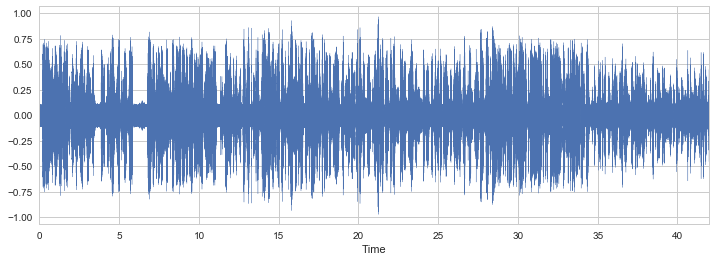

In [4]:
# Plot the sound wave
librosa.display.waveplot(y, sr=sr)

## Data Preprocessing

### Normalisation of input signal

In [9]:
y

array([ 0.06338501,  0.05831909,  0.05603027, ...,  0.20837402,
        0.04229736, -0.05917358], dtype=float32)

In [12]:
# Before normalisation
pd.Series(y).describe()

count    671744.000000
mean          0.060647
std           0.133882
min          -0.786469
25%           0.009308
50%           0.058777
75%           0.106567
max           0.969086
dtype: float64

In [13]:
# Normalisation of signal using same methodology as pyAudioAnalysis
y = (y - y.mean()) / ((np.abs(y)).max() + 0.0000000001)
y

array([ 0.00282511, -0.00240242, -0.00476425, ...,  0.15243934,
       -0.01893524, -0.12364316], dtype=float32)

In [14]:
# After normalisation
pd.Series(y).describe()

count    6.717440e+05
mean    -8.763181e-09
std      1.381537e-01
min     -8.741392e-01
25%     -5.297713e-02
50%     -1.930049e-03
75%      4.738502e-02
max      9.374181e-01
dtype: float64

So basically we subtracted the mean and scaled by the max

## Feature Engineering

We start with a simple model where we calculate short-term and mid-term features using similar parameters to `pyAudioAnalysis`:

* Short-term features: input signal is split into short-term widnows (frames) and the first 13 Mel-frequency cepstral coefficients a.k.a. **MFCCS** for each frame are calculated. The frame size is 50 ms and frame step of 25ms (50% overlap)


* Mid-term features: the signal is represented by statistics on the extracted short-term feature sequences described above. Here, the rolling mean and standard deviation is calculated over each short-term feature sequence using a longer time window

###  Short-term features

In [15]:
# Frame size == n_fft in librosa
50e-3*sr

800.0

In [16]:
# Frame step == hop_length in librosa
25e-3*sr

400.0

In [17]:
# Calculate short-term mfcss with the above frame size and step
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=800, hop_length=400)
mfccs.shape

(13, 1680)

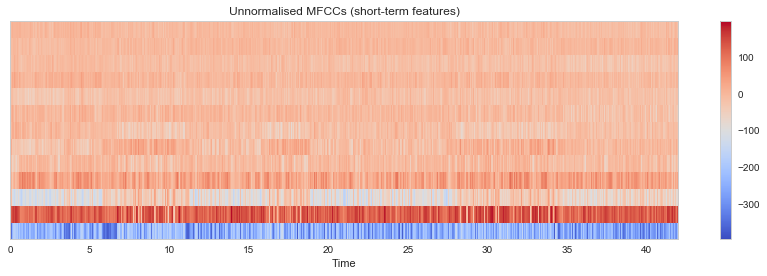

In [82]:
# Plot UNNORMALISED mfccs
# note here we need to manually calculate the x_coords given shampe of input array and in this case no need to input sr
t = librosa.frames_to_time(np.arange(mfccs.shape[1]), sr=sr, hop_length=400) # generates the correct time labels for mfccs shape
librosa.display.specshow(mfccs, x_axis='time', x_coords=t)
plt.colorbar()
plt.title('Unnormalised MFCCs (short-term features)')
plt.tight_layout()

#### A note on approximations in librosa

Note that due to nature of frame-bases analysis used to calculate the mfccs, which in librosa by default are centered, some approximations happen on librosa when it comes to duration and number of frames - see https://github.com/librosa/librosa/issues/691

In [25]:
# True duration of clip
duration = librosa.get_duration(y, sr=sr)
duration

41.984

In [27]:
librosa.samples_to_time(y.shape[0], sr=sr)

41.984000000000002

In [20]:
# Duration calculated from mfccs array using the same sampling freq as X
librosa.frames_to_time(mfccs.shape[1], sr=sr, hop_length=400)

42.0

In [21]:
# Generating the time range for the mfccs frames - note we are not feeding n_fft
t = librosa.frames_to_time(np.arange(mfccs.shape[1]), sr=sr, hop_length=400)
t

array([  0.00000000e+00,   2.50000000e-02,   5.00000000e-02, ...,
         4.19250000e+01,   4.19500000e+01,   4.19750000e+01])

In [30]:
librosa.frames_to_time(np.arange(mfccs.shape[1]), sr=sr, n_fft=800, hop_length=400)

array([  2.50000000e-02,   5.00000000e-02,   7.50000000e-02, ...,
         4.19500000e+01,   4.19750000e+01,   4.20000000e+01])

In [22]:
librosa.time_to_frames(times=t[-1], sr=sr, hop_length=400)

1679

In [26]:
librosa.time_to_frames(times=duration, sr=sr, n_fft=800, hop_length=400)

1678

In [24]:
mfccs.shape[1]

1680

### Mid-term Features

For the 13 mfccs, we calculate a rolling mean and standard deviation, using a window size of 80 (samples) and a stepsize of 8. This results in a a new array for each of 201 rows by 80 columns, using these window parameters. We use a `sliding_window` function borrowed from this [gist](https://gist.github.com/nils-werner/9d321441006b112a4b116a8387c2280c) (although note this has its problems as it ignores the last samples which don't fit into the shape). 

*TODO: change this window function.*

In [33]:
mfccs.shape

(13, 1680)

In [34]:
# Get the array split into sliding windows of 80 samples each and step=8 as in pyAudioAnalysis
mfccs_strided = handy_functions.sliding_window(mfccs, size=80, stepsize=8)
mfccs_strided.shape

(13, 201, 80)

In [35]:
# Get rolling mean (note using axis=2)
_mean = np.mean(mfccs_strided, axis=2)
_mean.shape

(13, 201)

In [36]:
# Get rolling std (note using axis=2)
_std = np.std(mfccs_strided, axis=2)
_std.shape

(13, 201)

We use the mid-term MFCCs mean and std as the final feature matrix

In [37]:
# Join mean and std into single array
X = np.concatenate((_mean, _std))
X.shape

(26, 201)

Note that above seems to be in the form (n_features, n_samples), so would need to transpose before feeding into algo

In [38]:
# Get transpose to put into (n_samples, n_features) shape
X = X.T
X.shape

(201, 26)

#### Normalisation

The below shows that our feature matrix still requires normalisation:

In [39]:
# Get some stats
temp = pd.DataFrame(X)
temp.describe()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,...,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,-245.127777,121.577330,-63.719774,35.209545,-6.557960,-1.930880,-17.661280,-3.384814,-17.504400,1.954868,...,25.290382,16.883527,18.324953,14.899721,13.081371,11.713035,11.293442,9.962979,9.063771,8.582099
std,17.391801,8.438716,25.740738,7.003356,5.457450,14.788428,10.519948,7.528504,4.754187,5.043541,...,3.190758,3.483073,3.403508,3.053629,2.496182,1.584406,1.655463,1.483743,1.355520,1.520334
min,-283.439431,97.377573,-111.997627,19.240987,-22.036460,-31.591596,-37.808908,-23.710529,-33.778027,-10.053211,...,18.039936,10.204290,10.499833,8.628940,7.787906,8.735905,8.029104,6.733605,6.457152,5.500652
25%,-257.128559,116.587724,-85.729070,30.150283,-9.860182,-14.459085,-29.251630,-4.757087,-19.243991,-0.631683,...,23.212049,14.116595,15.941481,12.263846,11.006535,10.750215,9.952187,8.707773,7.972932,7.406690
50%,-245.261535,122.321907,-68.349145,35.472009,-6.237386,-3.440410,-14.775990,-1.802381,-17.166333,1.708786,...,25.420821,16.580721,18.783312,14.665163,13.377719,11.468817,11.252575,10.135479,8.896602,8.812245
75%,-231.467735,127.693245,-38.541086,40.169103,-3.290296,11.078458,-10.029935,1.403362,-14.791820,4.612843,...,27.820325,19.718946,20.588488,16.304491,14.816776,12.777160,12.587972,11.142089,9.998411,9.643833
max,-209.231810,143.488326,-19.219165,54.128662,5.438234,25.418079,3.186288,9.335412,-6.404935,15.404435,...,32.807062,26.486837,26.846477,23.534923,18.349363,16.421768,14.840286,12.887709,12.308043,11.799906


Clearly we need to normalise this before feeding into algo

In [40]:
# Scale to zero mean and unit std
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(201, 26)

The mean is now nearly zero and the std nearly 1 for all:

In [41]:
temp = pd.DataFrame(X_scaled)
temp.describe()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,...,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02
mean,-5.236276e-16,1.226216e-15,7.042459e-17,3.170488e-16,-7.953837e-17,6.569510e-17,2.016077e-16,-1.082606e-16,-1.906988e-16,-3.424569e-17,...,-2.551856e-16,-5.838337e-16,6.318881e-16,-2.794890e-16,2.043694e-16,-4.606597e-16,-1.888346e-16,-1.283626e-15,2.159688e-16,1.488583e-16
std,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,...,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00
min,-2.208358e+00,-2.874866e+00,-1.880226e+00,-2.285823e+00,-2.843296e+00,-2.010679e+00,-1.919965e+00,-2.706576e+00,-3.431556e+00,-2.386827e+00,...,-2.278001e+00,-1.922416e+00,-2.304874e+00,-2.058678e+00,-2.125919e+00,-1.883711e+00,-1.976781e+00,-2.181939e+00,-1.927767e+00,-2.031882e+00
25%,-6.917482e-01,-5.927518e-01,-8.571724e-01,-7.242091e-01,-6.065961e-01,-8.492780e-01,-1.104501e+00,-1.827321e-01,-3.668208e-01,-5.141248e-01,...,-6.529865e-01,-7.963774e-01,-7.020473e-01,-8.653496e-01,-8.332793e-01,-6.092022e-01,-8.122223e-01,-8.480845e-01,-8.067471e-01,-7.750553e-01
50%,-7.710062e-03,8.845372e-02,-1.802952e-01,3.757045e-02,5.888727e-02,-1.023299e-01,2.749534e-01,2.107170e-01,7.128694e-02,-4.891333e-02,...,4.098241e-02,-8.715350e-02,1.350087e-01,-7.700458e-02,1.190167e-01,-1.545232e-01,-2.474786e-02,1.165508e-01,-1.236322e-01,1.517570e-01
75%,7.873911e-01,7.265543e-01,9.806073e-01,7.099370e-01,6.002479e-01,8.818937e-01,7.272279e-01,6.375942e-01,5.719912e-01,5.283218e-01,...,7.948771e-01,8.160894e-01,6.667200e-01,4.611815e-01,6.969595e-01,6.733007e-01,7.839269e-01,7.966705e-01,6.912286e-01,7.000997e-01
max,2.069113e+00,2.602968e+00,1.733117e+00,2.708181e+00,2.203620e+00,1.853966e+00,1.986666e+00,1.693827e+00,2.340501e+00,2.673350e+00,...,2.361648e+00,2.764021e+00,2.509999e+00,2.834910e+00,2.115689e+00,2.979344e+00,2.147858e+00,1.976106e+00,2.399353e+00,2.121798e+00


Now we want to plot the **normalised** mfccs, but for that we need to generate the correct time range for the `librosa.display.specshow` function:

In [42]:
duration

41.984

In [43]:
X_scaled.shape

(201, 26)

In [77]:
# Infer the sampling rate by dividing the shape minus 1 divided by duration (only this matches the duration)
sr_X = (X_scaled.shape[0] - 1)/duration
t = librosa.samples_to_time(np.arange(X_scaled.shape[0]), sr=sr_X)
t

array([  0.     ,   0.20992,   0.41984,   0.62976,   0.83968,   1.0496 ,
         1.25952,   1.46944,   1.67936,   1.88928,   2.0992 ,   2.30912,
         2.51904,   2.72896,   2.93888,   3.1488 ,   3.35872,   3.56864,
         3.77856,   3.98848,   4.1984 ,   4.40832,   4.61824,   4.82816,
         5.03808,   5.248  ,   5.45792,   5.66784,   5.87776,   6.08768,
         6.2976 ,   6.50752,   6.71744,   6.92736,   7.13728,   7.3472 ,
         7.55712,   7.76704,   7.97696,   8.18688,   8.3968 ,   8.60672,
         8.81664,   9.02656,   9.23648,   9.4464 ,   9.65632,   9.86624,
        10.07616,  10.28608,  10.496  ,  10.70592,  10.91584,  11.12576,
        11.33568,  11.5456 ,  11.75552,  11.96544,  12.17536,  12.38528,
        12.5952 ,  12.80512,  13.01504,  13.22496,  13.43488,  13.6448 ,
        13.85472,  14.06464,  14.27456,  14.48448,  14.6944 ,  14.90432,
        15.11424,  15.32416,  15.53408,  15.744  ,  15.95392,  16.16384,
        16.37376,  16.58368,  16.7936 ,  17.00352, 

In [65]:
duration

41.984

In [76]:
t[-1]

41.984000000000002

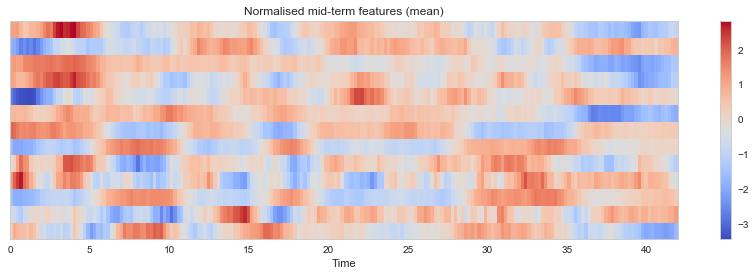

In [396]:
# Plot NORMALISED mid-term features (rolling mean and std of mels)
# note here we need to manually calculate the x_coords given shampe of input array and in this case no need to input sr
sr_X = (X_scaled.shape[0] - 1)/duration
t = librosa.samples_to_time(np.arange(X_scaled.shape[0]), sr=sr_X)
librosa.display.specshow(X_scaled[:, 0:13].T, x_axis='time', x_coords=t)
plt.colorbar()
plt.title('Normalised mid-term features (mean)')
plt.tight_layout()

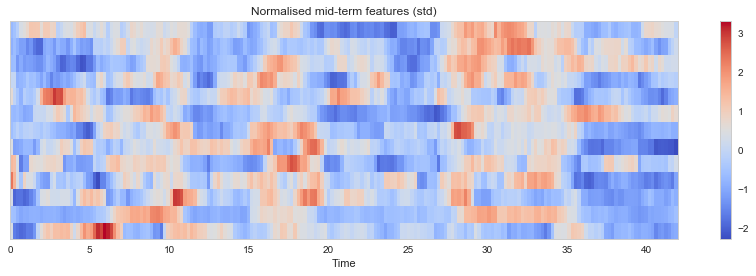

In [409]:
# Plot NORMALISED mid-term features (rolling mean and std of mels)
# note here we need to manually calculate the x_coords given shampe of input array and in this case no need to input sr
sr_X = (X_scaled.shape[0] - 1)/duration
t = librosa.samples_to_time(np.arange(X_scaled.shape[0]), sr=sr_X)
librosa.display.specshow(X_scaled[:, 13:].T, x_axis='time', x_coords=t)
plt.colorbar()
plt.title('Normalised mid-term features (std)')
plt.tight_layout()

## Unsupervised classification

For this we use `sklearn` k-Means clustering.

**Parameters**

* `n_clusters=4`: A drawback of this algo though is that the number of clusters (and hence speakers in this case) needs to be selected as the parameters `n_clusters`. Later we will investigate how to determine the number of speakers when this is not known by using `sklearn` [Silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

* `random_state=0`: the seed used by the random number generator, to get same result everytime code is ran

In [85]:
# Assuming 4 speakers (which is also the ground truth)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
# Note that X is in form (n_samples, n_features)
labels = kmeans.fit_predict(X_scaled)
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [86]:
labels.shape

(201,)

In [87]:
kmeans.cluster_centers_.shape

(4, 26)

i.e. 4 labels in 26 dimensions (features)

In [88]:
t

array([  0.     ,   0.20992,   0.41984,   0.62976,   0.83968,   1.0496 ,
         1.25952,   1.46944,   1.67936,   1.88928,   2.0992 ,   2.30912,
         2.51904,   2.72896,   2.93888,   3.1488 ,   3.35872,   3.56864,
         3.77856,   3.98848,   4.1984 ,   4.40832,   4.61824,   4.82816,
         5.03808,   5.248  ,   5.45792,   5.66784,   5.87776,   6.08768,
         6.2976 ,   6.50752,   6.71744,   6.92736,   7.13728,   7.3472 ,
         7.55712,   7.76704,   7.97696,   8.18688,   8.3968 ,   8.60672,
         8.81664,   9.02656,   9.23648,   9.4464 ,   9.65632,   9.86624,
        10.07616,  10.28608,  10.496  ,  10.70592,  10.91584,  11.12576,
        11.33568,  11.5456 ,  11.75552,  11.96544,  12.17536,  12.38528,
        12.5952 ,  12.80512,  13.01504,  13.22496,  13.43488,  13.6448 ,
        13.85472,  14.06464,  14.27456,  14.48448,  14.6944 ,  14.90432,
        15.11424,  15.32416,  15.53408,  15.744  ,  15.95392,  16.16384,
        16.37376,  16.58368,  16.7936 ,  17.00352, 

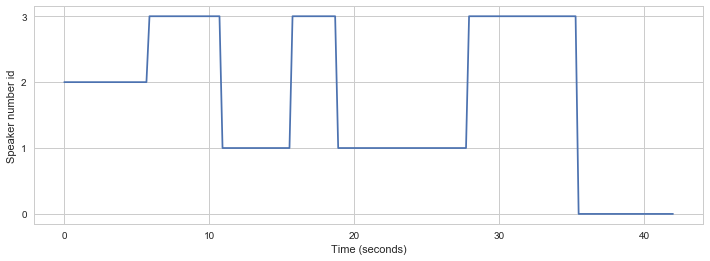

In [105]:
# Use the previously generated time range for the shape of X to plot labels vs time
plt.plot(t, labels)
plt.yticks(np.unique(labels).astype(int))
plt.ylabel('Speaker number id')
plt.xlabel('Time (seconds)')

Indeed, if we play the audio file below, we can see the labels indeed separate the different speakers over time

In [252]:
ipd.Audio(fn)

## Ground truth

In [386]:
# Compare to ground-truth to see the overall performance of the classification
truth = pd.read_csv('data/diarization/diarizationExample.segments', names=['start', 'end', 'speaker'])
truth

,start,end,speaker
0,0.0,6.3,speakerA
1,6.3,11.3,speakerB
2,11.3,15.8,sxpeakerC
3,15.8,18.8,speakerB
4,18.8,27.8,speakerC
5,27.8,34.4,speakerB
6,34.4,42.0,speakerD


In [225]:
# First map speakers to same labels from k-means
truth['labels'] = np.where(truth['speaker'] == 'speakerA', 2, 
                           np.where(truth['speaker'] == 'speakerB', 3, 
                                    np.where(truth['speaker'] == 'speakerC', 1,
                                    np.where(truth['speaker'] == 'speakerD', 0, np.nan)))).astype(int)
truth

,start,end,speaker,labels
0,0.0,6.3,speakerA,2
1,6.3,11.3,speakerB,3
2,11.3,15.8,speakerC,1
3,15.8,18.8,speakerB,3
4,18.8,27.8,speakerC,1
5,27.8,34.4,speakerB,3
6,34.4,42.0,speakerD,0


In [226]:
d = truth[['start', 'labels']].to_dict(orient='list')
d

{'labels': [2, 3, 1, 3, 1, 3, 0],
 'start': [0.0, 6.3, 11.3, 15.8, 18.8, 27.8, 34.4]}

In [238]:
# This is an O(n) solution
speakers = []
i = 0
for it in t:
    if i + 1 >= len(d['start']):
        speakers += [d['labels'][i]]
    elif it < d['start'][i + 1]:
        speakers += [d['labels'][i]]
    else:
        i += 1
        speakers += [d['labels'][i]]
    # print(i, it, len(speakers))  # for debugging

In [239]:
len(speakers)

201

In [412]:
# Transform into df to get meeting metrics
df = pd.DataFrame(index=t, data={'truth': speakers, 'kmeans': labels.tolist()})
df.head()

# Assuming categories but then can't easily plot it
# df = pd.DataFrame(index=t, data={'truth': ['speaker' + str(x) for x in speakers], 
#                                  'kmeans': ['speaker' + str(x) for x in labels.tolist()]})

,kmeans,truth
0.00000,2,2
0.20992,2,2
0.41984,2,2
0.62976,2,2
0.83968,2,2


## Meeting visualisation & metrics

#### Speaker timeline

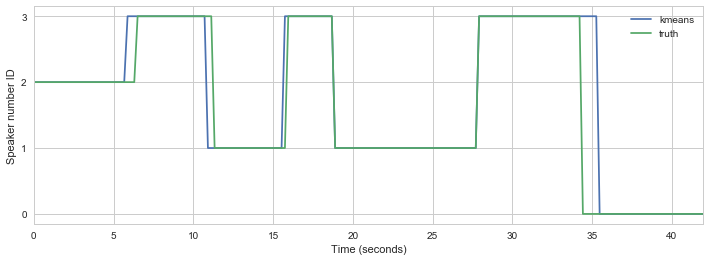

In [413]:
# Speaker timeline
df.plot()
plt.yticks(np.unique(df['truth']).astype(int))
plt.ylabel('Speaker number ID')
plt.xlabel('Time (seconds)')
plt.legend()

#### Who spoke the longest in total?

In [288]:
df['time'] = df.index

In [327]:
# We see constant time intervals
df['time'].diff(1).tail()

41.14432    0.20992
41.35424    0.20992
41.56416    0.20992
41.77408    0.20992
41.98400    0.20992
Name: time, dtype: float64

In [290]:
df['time'].diff(1).iloc[-1]

0.20992000000000388

In [303]:
df.groupby('kmeans').count()[['time']]

,time
kmeans,
0,32
1,66
2,28
3,75


In [306]:
t_step = df['time'].diff(1).iloc[-1]
speaker_duration = (df.groupby('kmeans').count()[['time']] * t_step).sort_values(by=['time'], ascending=False)
speaker_duration

,time
kmeans,
3,15.74400
1,13.85472
0,6.71744
2,5.87776


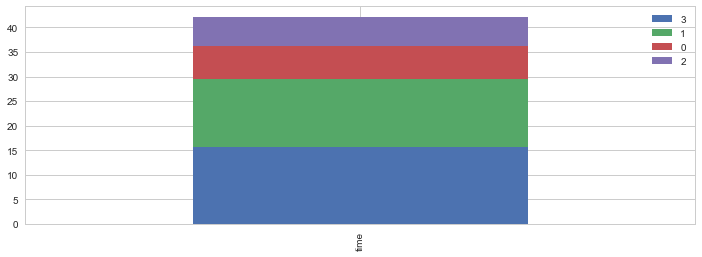

In [326]:
# Stacked bar chart (but difficult to show labels)
speaker_duration.T.plot.bar(stacked=True)
plt.legend()

In [319]:
speaker_duration.index.tolist()

[3, 1, 0, 2]

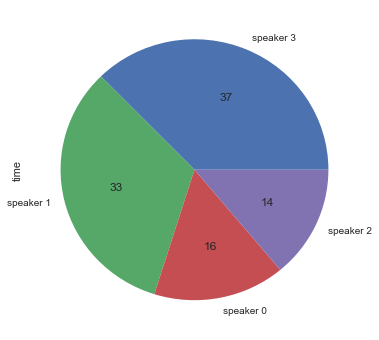

In [325]:
# Pie chart of percentage time
speaker_duration['time'].plot.pie(labels=['speaker '+ str(x) for x in speaker_duration.index.tolist()],
                                 autopct='%.f',
                                 figsize=(6, 6))

#### Number of different times each speaker spoke

In [379]:
df[df['kmeans'].diff(1) != 0]

,kmeans,truth,time
0.00000,2,2,0.00000
5.87776,3,2,5.87776
10.91584,1,3,10.91584
15.74400,3,1,15.74400
18.89280,1,1,18.89280
27.91936,3,3,27.91936
35.47648,0,0,35.47648


In [383]:
# Grouped by
df[df['kmeans'].diff(1) != 0].groupby('kmeans').count()

,truth,time
kmeans,,
0,1,1
1,2,2
2,1,1
3,3,3


In [382]:
# Sorted
df[df['kmeans'].diff(1) != 0].groupby('kmeans').count().sort_values(by='time', ascending=False)

,truth,time
kmeans,,
3,3,3
1,2,2
0,1,1
2,1,1
